# The M2 Model

The M2 model generalizes the VAE by learning the distribution of a dataset $\mathbf{x}_1, \mathbf{x}_2, \dots, \mathbf{x}_n$ given they are sampled conditioned on a latent $\mathbf{z}$ sampled as a standard Gaussian vector (like the VAE) and a categorical condition $c$. Below, we show an implementation of the M2 model of top of the standard VAE:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import random
from tqdm import tqdm
import torchvision
import torchvision.datasets as datasets

#for consistency, all seeds are set to 69420
seed = 69420
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [32]:
# Kuhn-Munkres algorithm - aligns unsupervised labels such that the accuracy is maximized with the true label
from scipy.optimize import linear_sum_assignment
def align_hard_labels(y_pred, y_true, num_classes):
    cost_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)
    for i in range(num_classes):
        for j in range(num_classes):
            cost_matrix[i, j] = np.sum((y_pred == i) & (y_true == j))
    row_ind, col_ind = linear_sum_assignment(-cost_matrix)
    perm = dict(zip(row_ind, col_ind))
    aligned_pred = np.vectorize(lambda x: perm.get(x, x))(y_pred)
    return aligned_pred

def plot_accuracy(y_pred, y_true, num_classes, title="Per-Class Accuracy"):
    accuracies = np.zeros(num_classes)
    
    for cls in range(num_classes):
        idx = (y_true == cls)
        if np.sum(idx) > 0:
            accuracies[cls] = np.mean(y_pred[idx] == y_true[idx])
        else:
            accuracies[cls] = 0.0

    # Plot
    plt.figure(figsize=(8, 5))
    plt.bar(np.arange(num_classes), accuracies)
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.xticks(np.arange(num_classes))
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

Dataset: MNIST as per usual

<Figure size 640x480 with 0 Axes>

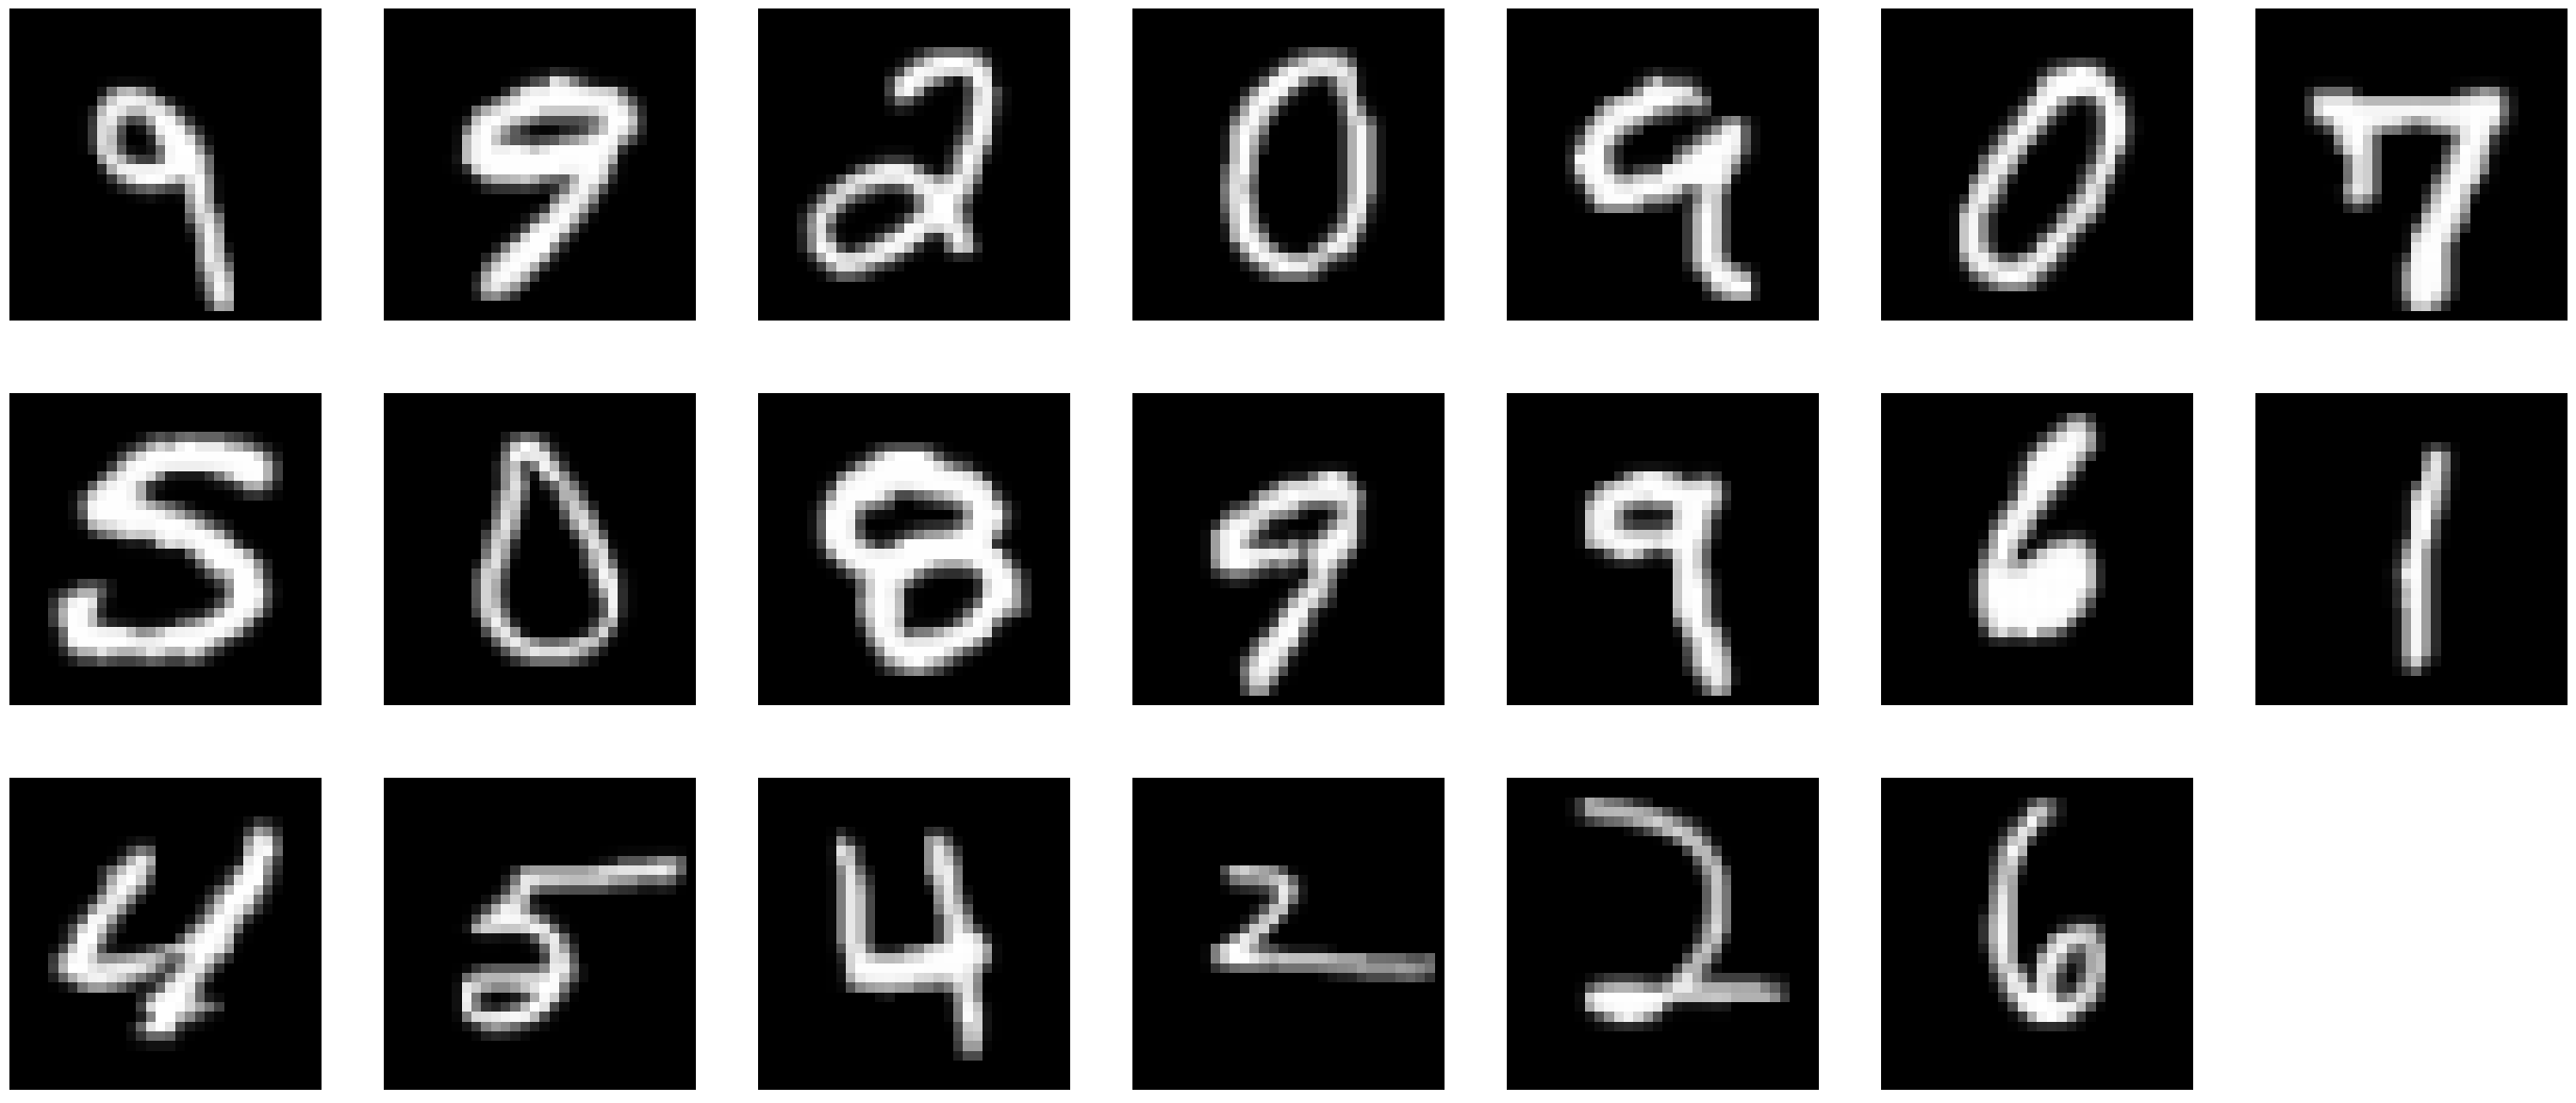

In [2]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32,32)),
    torchvision.transforms.ToTensor()
])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
data_loader = torch.utils.data.DataLoader(mnist_trainset,batch_size=128,shuffle=True,num_workers=1)

plt.gray()

def plotter(images):
    f = -(-len(images)//3)
    fig,ax = plt.subplots(3,f,figsize=(5*f, 15))
    for i in range(len(images)):
        ax[i%3,i//3].imshow(images[i,0])
    for aa in ax:
        for aaa in aa:
            aaa.axis("off")
    plt.show()

for a, b in data_loader:
    plotter(a[0:20])
    break

## Encoder

We made the following modifications to the encoder: the network additionally predicts the class $c$, which is trained unsupervisedly with the rest of the network using cross entropy.

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size, img_channel, num_classes):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channel, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.mu_fc = nn.Conv2d(256, latent_size, 2, 1, 0, bias=False)
        self.sigma_fc = nn.Conv2d(256, latent_size, 2, 1, 0, bias=False)
        self.c_fc = nn.Conv2d(256, num_classes, 2, 1, 0, bias=False)
        self.z_kl = 0
        self.num_classes = num_classes
        
    def forward(self,x,normal_generator):
        encoded = self.encoder(x)
        
        # z-related terms
        mu = self.mu_fc(encoded).mean([-2,-1]) #mean
        sigma = torch.exp(self.sigma_fc(encoded).mean([-2,-1])) #covariance
        z = mu + sigma*normal_generator.sample(mu.shape) #randomly sample from latent
        self.z_kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum() # kl loss term
        
        # c-related terms
        c_logits = self.c_fc(encoded).mean([-2,-1])
        c_log_probs = torch.nn.functional.log_softmax(c_logits, dim=1)
        cross_entropy = -torch.sum(1/self.num_classes * c_log_probs, dim=1).mean()
        self.c_ce = cross_entropy
        
        # return z and c concatenated together
        return torch.cat([z, torch.nn.functional.softmax(c_logits, dim=1)], dim=1)

## Decoder

We use the same decoder architecture albeit with one slight modification: the decoder now inputs $\mathbf{z}$ and $c$ as part of its "latent"

In [4]:
class Decoder(nn.Module):
    
    def __init__(self, latent_size, img_channel, num_classes):
        
        super(Decoder, self).__init__()

        self.conv_transpose_block_1 = nn.Sequential(
            nn.ConvTranspose2d(latent_size+num_classes, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True))

        self.conv_transpose_block_2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True))

        self.conv_transpose_block_3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True))

        self.conv_transpose_block_4 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True))

        self.conv_transpose_block_5 = nn.Sequential(
            nn.ConvTranspose2d(32, img_channel, 1, 1, 0, bias=False),
            nn.Sigmoid())

    def forward(self, x):
        x = self.conv_transpose_block_1(x)
        x = self.conv_transpose_block_2(x)
        x = self.conv_transpose_block_3(x)
        x = self.conv_transpose_block_4(x)
        x = self.conv_transpose_block_5(x)
        return x

## VAE training
We still optimize the ELBO stochastically using the gradient descent, which boils down the minimizing the KL divergence and reconstruction terms.

In [5]:
latent_size = 128
img_ch = 1
num_epochs = 20
num_classes = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
normal_generator = torch.distributions.Normal(torch.tensor(0).float().to(device), torch.tensor(1).float().to(device))

enc = Encoder(latent_size, img_ch, num_classes).to(device)
dec = Decoder(latent_size, img_ch, num_classes).to(device)

optimizer = torch.optim.Adam(list(enc.parameters())+list(dec.parameters()), lr=0.0002, betas=(0.5, 0.999))

0it [00:00, ?it/s]

Iteration 469/469	[Epoch 1/20]	Losses:	KL = 52.7855 	L2 = 61.9095	CE = 0.0353: : 469it [00:12, 37.87it/s]


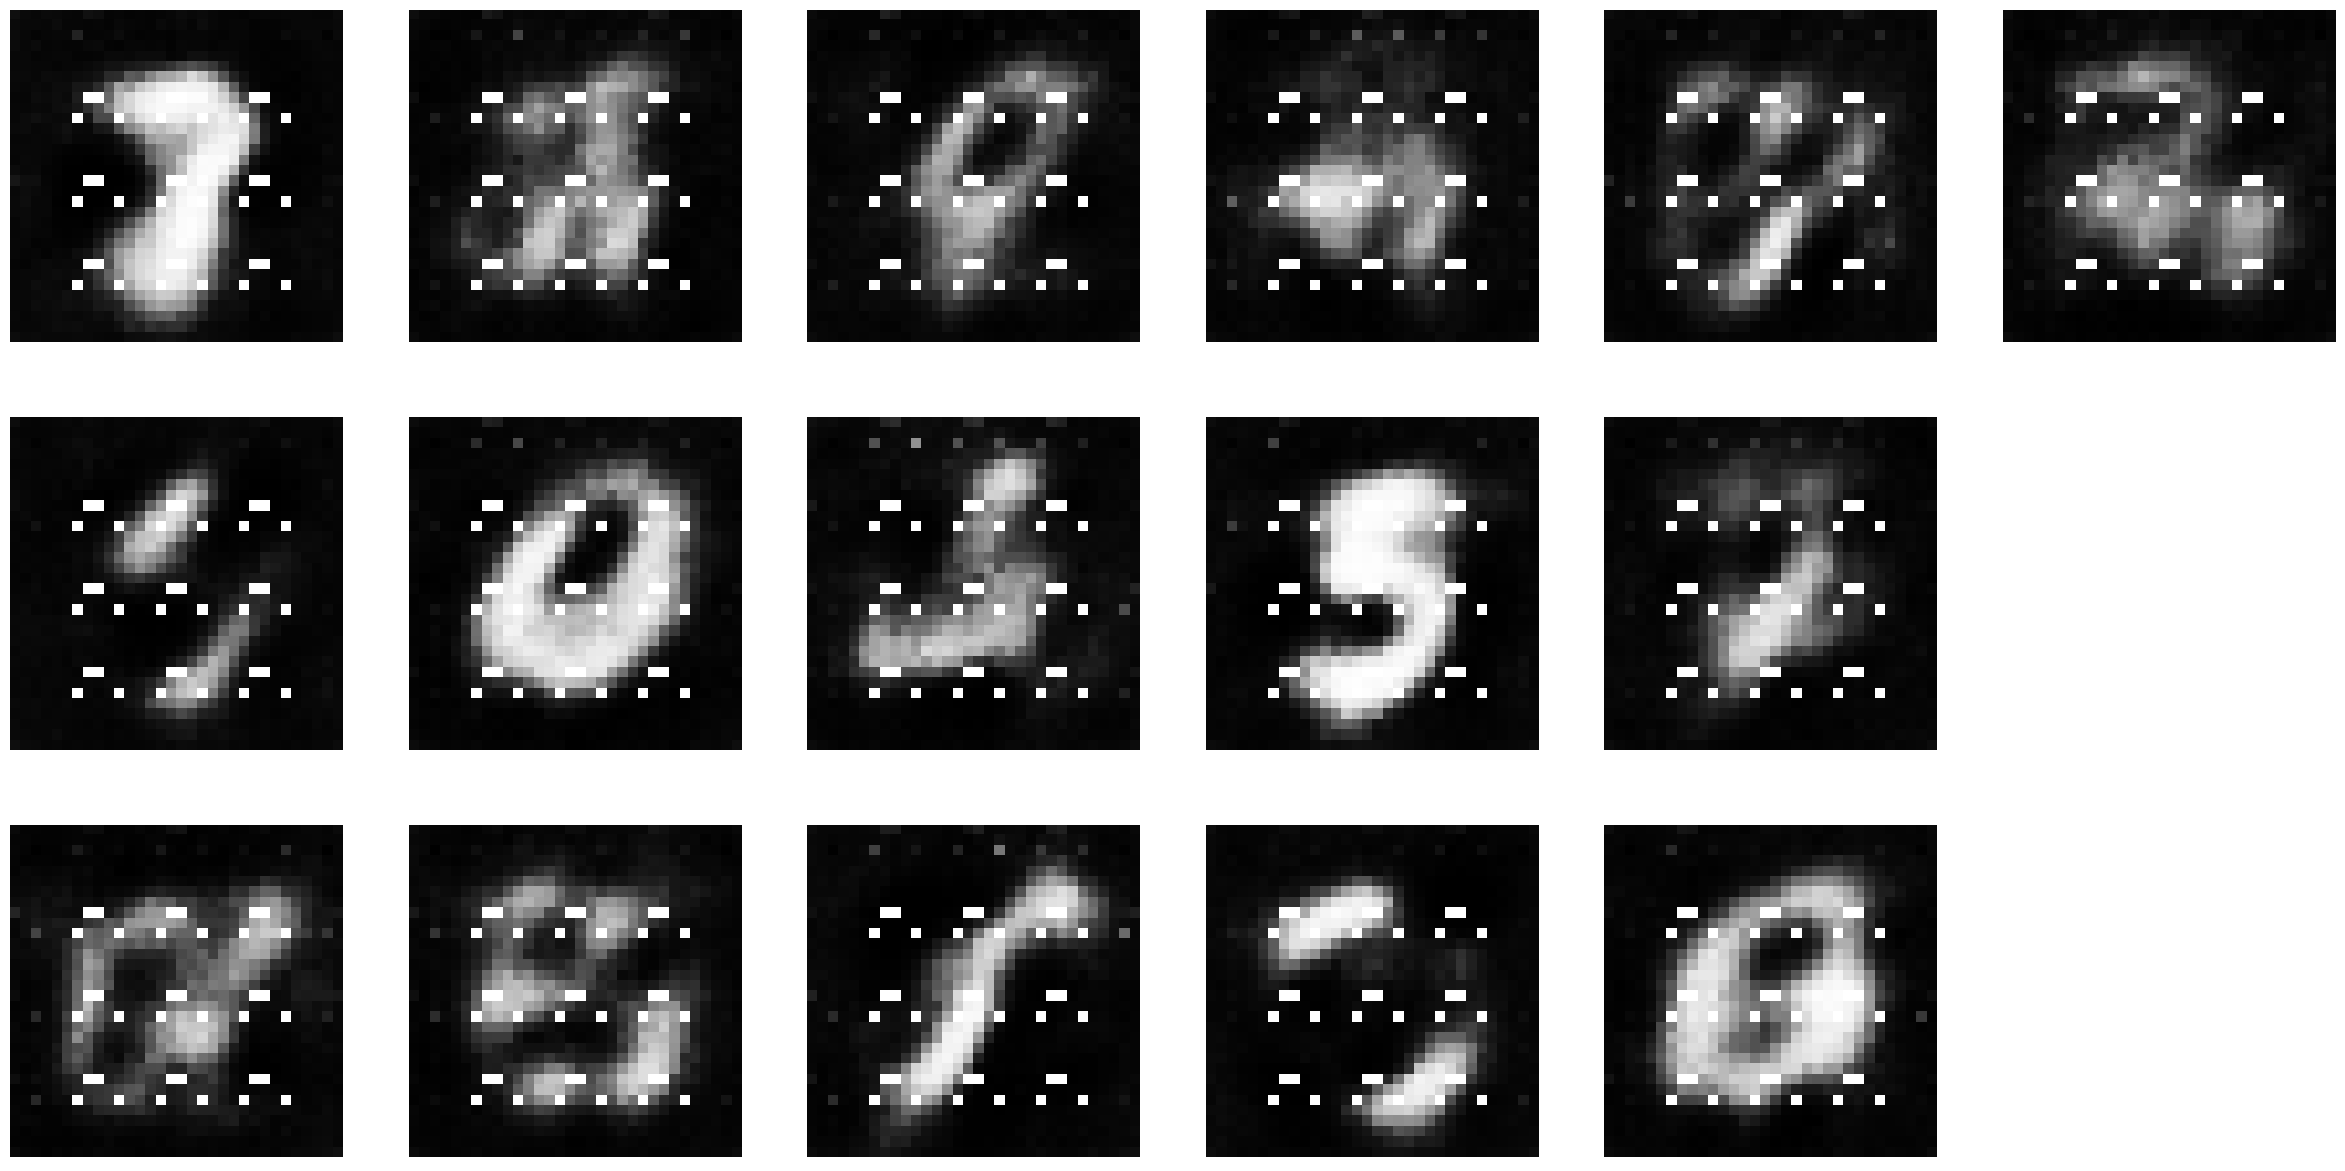

Iteration 469/469	[Epoch 2/20]	Losses:	KL = 52.3684 	L2 = 47.1758	CE = 0.0348: : 469it [00:08, 52.54it/s]
Iteration 469/469	[Epoch 3/20]	Losses:	KL = 51.9875 	L2 = 44.1980	CE = 0.0334: : 469it [00:08, 53.46it/s]
Iteration 469/469	[Epoch 4/20]	Losses:	KL = 51.3942 	L2 = 42.2530	CE = 0.0313: : 469it [00:08, 54.15it/s]
Iteration 469/469	[Epoch 5/20]	Losses:	KL = 50.9260 	L2 = 40.8235	CE = 0.0288: : 469it [00:08, 54.57it/s]


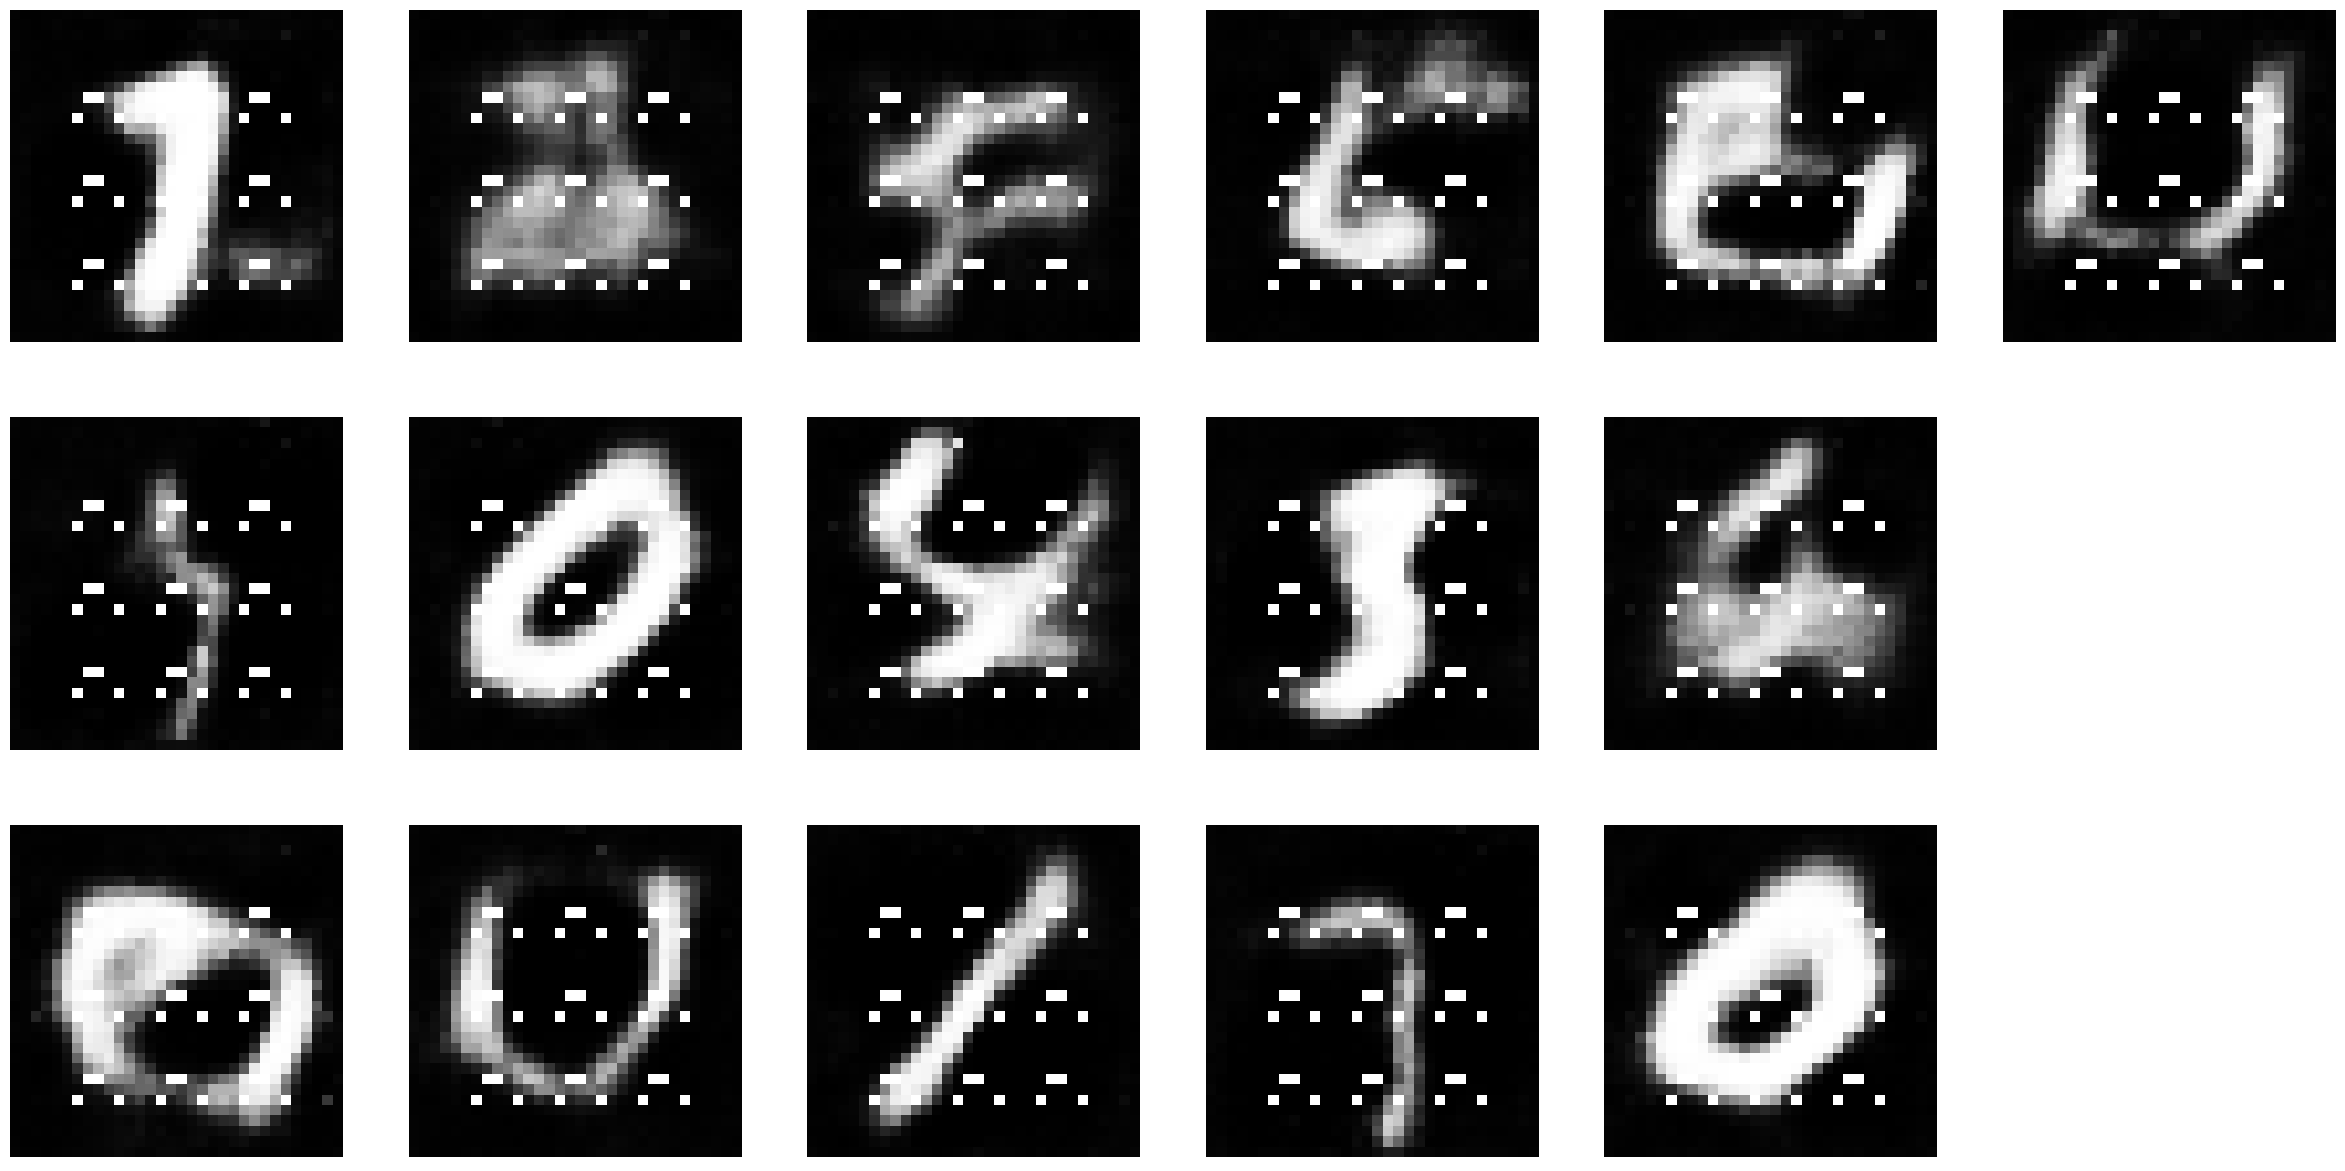

Iteration 469/469	[Epoch 6/20]	Losses:	KL = 50.5051 	L2 = 36.8323	CE = 0.0272: : 469it [00:09, 49.97it/s]
Iteration 469/469	[Epoch 7/20]	Losses:	KL = 50.1096 	L2 = 32.7607	CE = 0.0246: : 469it [00:11, 42.51it/s]
Iteration 469/469	[Epoch 8/20]	Losses:	KL = 49.6864 	L2 = 26.4677	CE = 0.0226: : 469it [00:08, 52.52it/s]
Iteration 469/469	[Epoch 9/20]	Losses:	KL = 49.3656 	L2 = 14.3283	CE = 0.0222: : 469it [00:08, 55.11it/s]


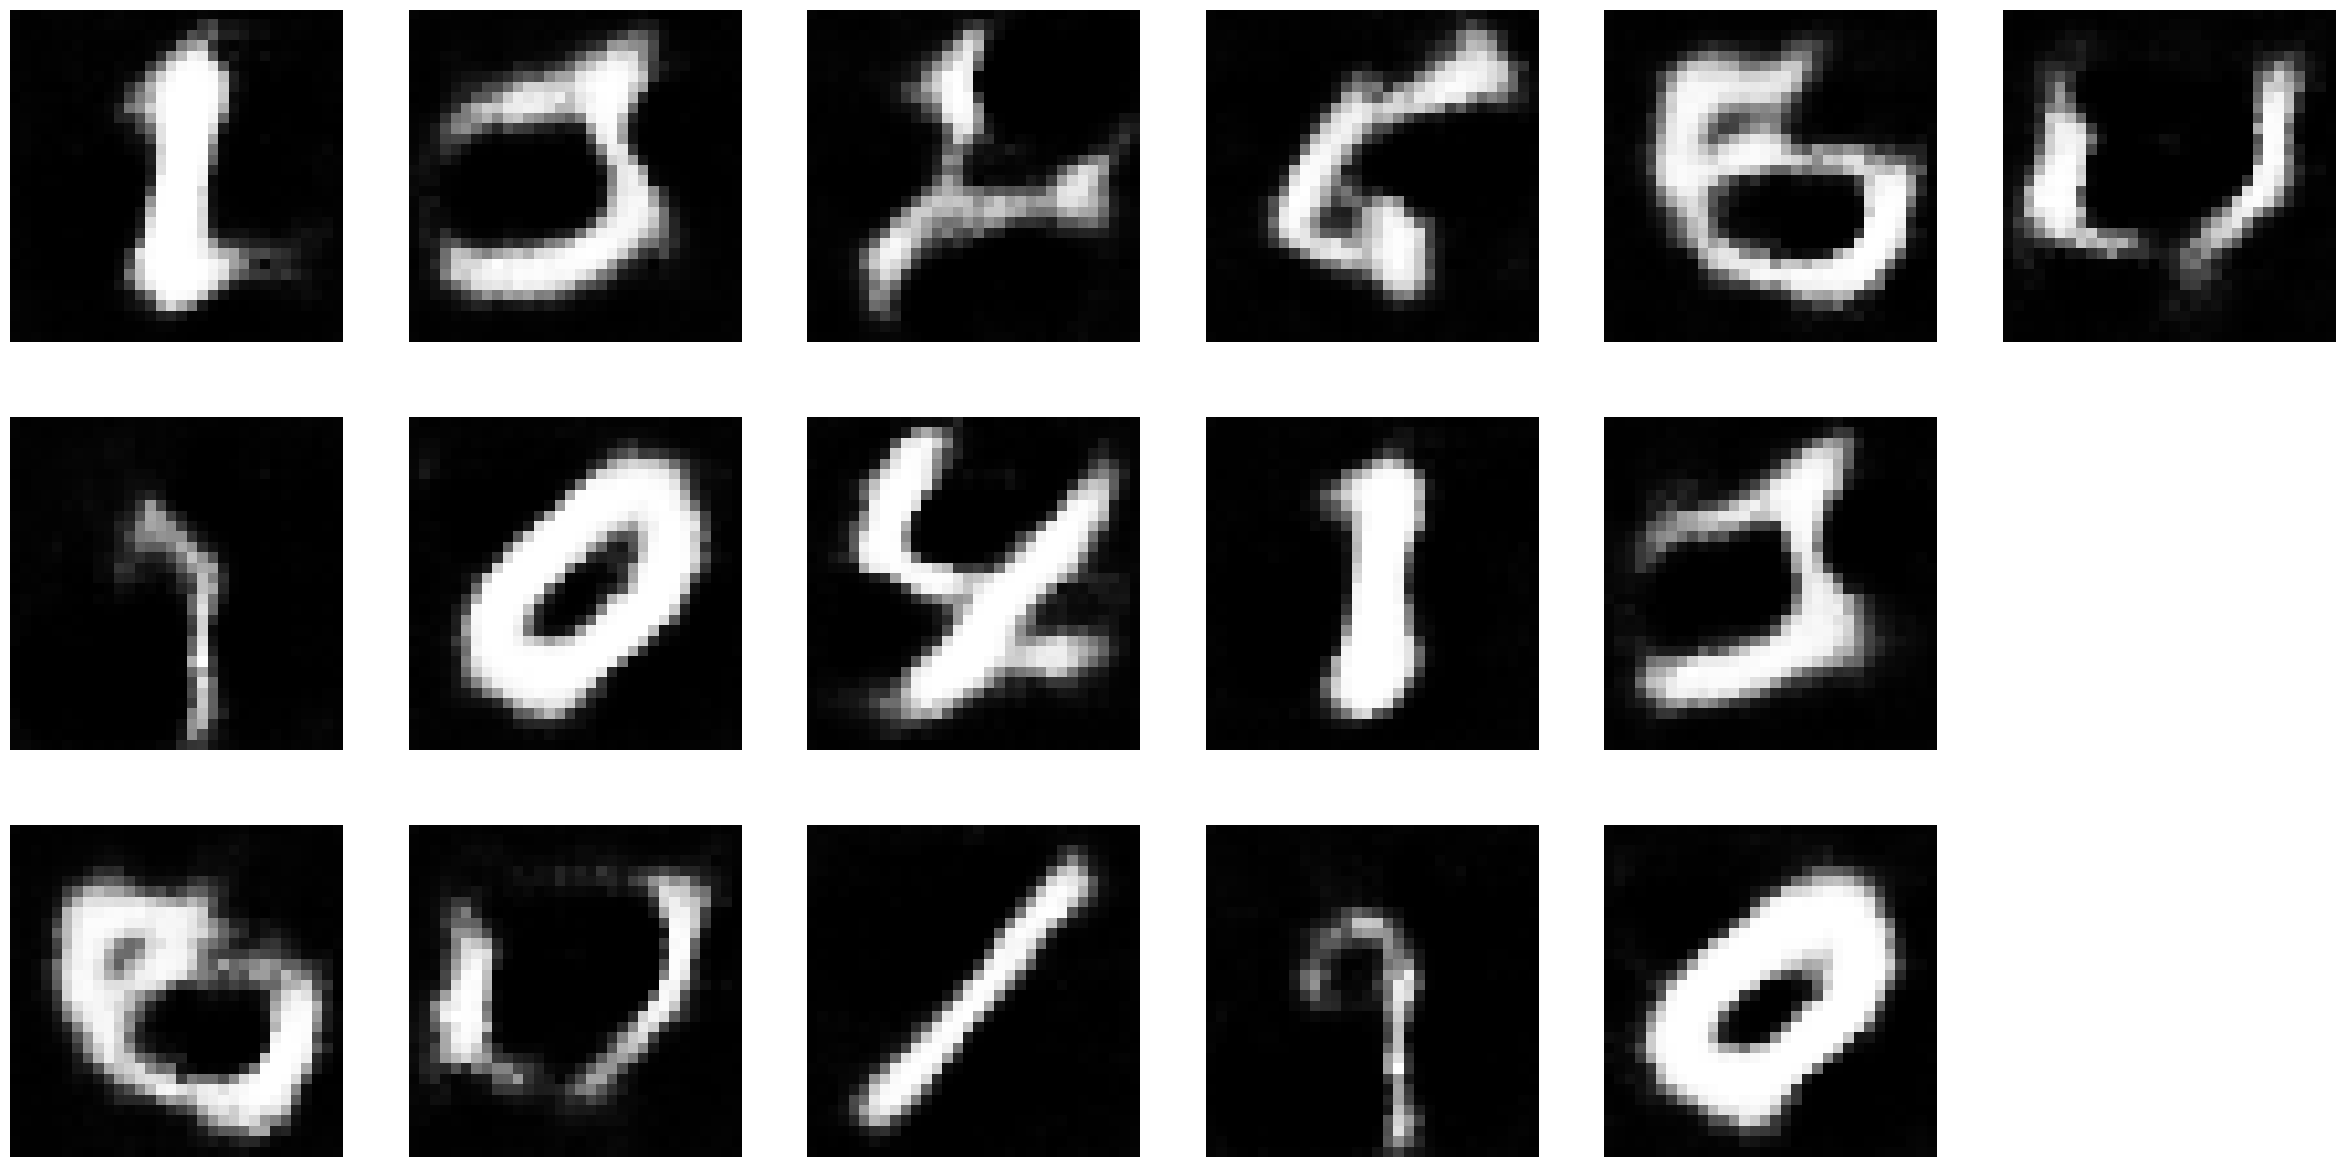

Iteration 469/469	[Epoch 10/20]	Losses:	KL = 49.0463 	L2 = 12.7530	CE = 0.0220: : 469it [00:08, 52.49it/s]
Iteration 469/469	[Epoch 11/20]	Losses:	KL = 48.7740 	L2 = 12.1962	CE = 0.0220: : 469it [00:08, 52.70it/s]
Iteration 469/469	[Epoch 12/20]	Losses:	KL = 48.5463 	L2 = 11.7492	CE = 0.0219: : 469it [00:08, 54.74it/s]
Iteration 469/469	[Epoch 13/20]	Losses:	KL = 48.3527 	L2 = 11.4734	CE = 0.0218: : 469it [00:08, 53.66it/s]


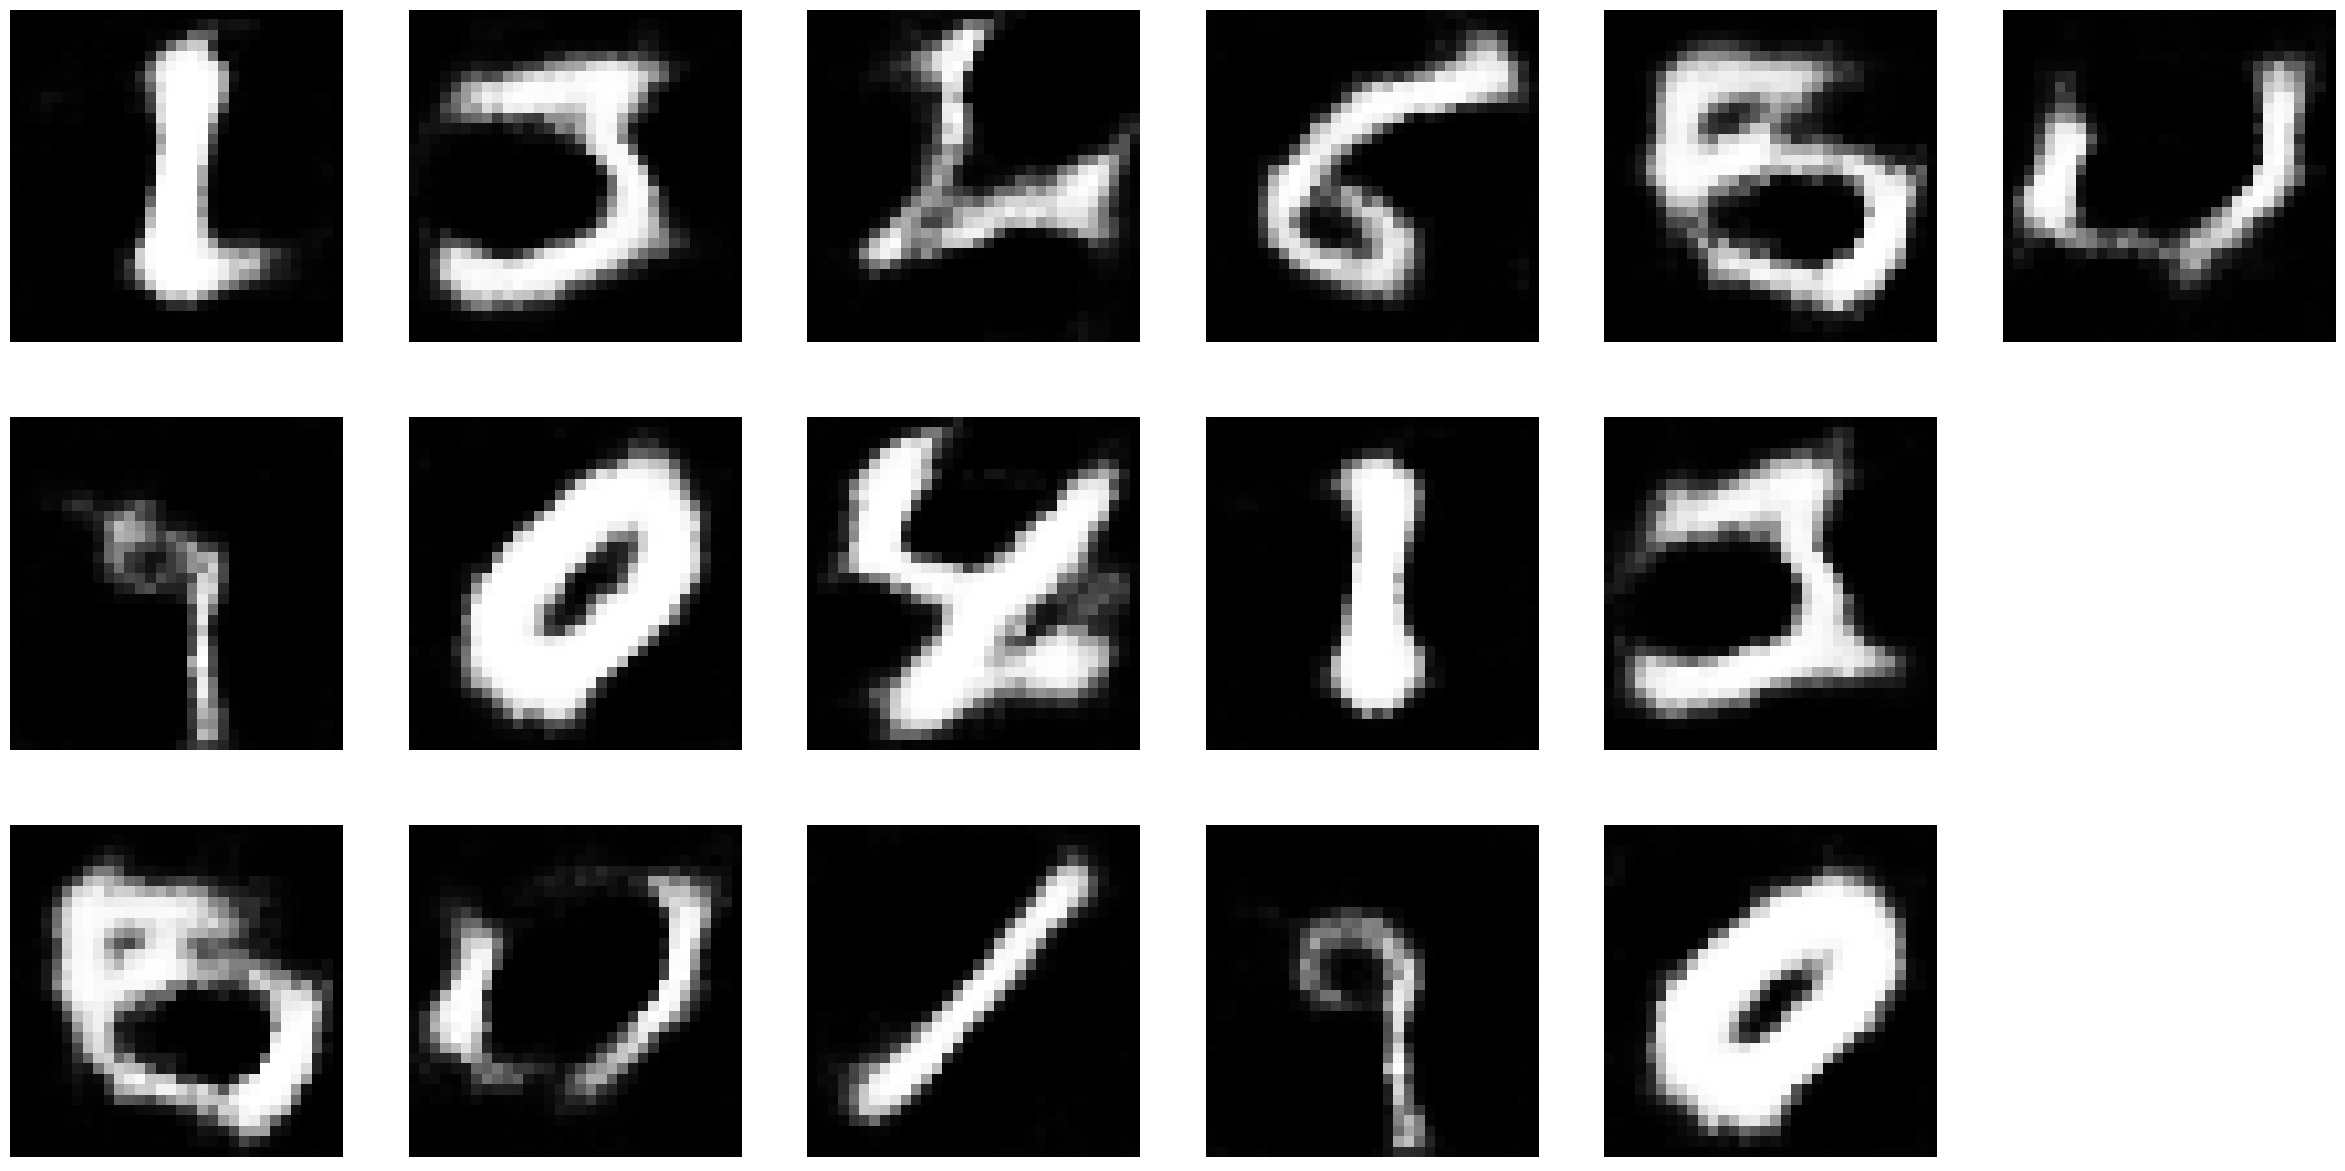

Iteration 469/469	[Epoch 14/20]	Losses:	KL = 48.1700 	L2 = 11.1987	CE = 0.0216: : 469it [00:08, 54.16it/s]
Iteration 469/469	[Epoch 15/20]	Losses:	KL = 48.0296 	L2 = 10.9862	CE = 0.0215: : 469it [00:08, 52.86it/s]
Iteration 469/469	[Epoch 16/20]	Losses:	KL = 47.8462 	L2 = 10.7610	CE = 0.0214: : 469it [00:09, 49.73it/s]
Iteration 469/469	[Epoch 17/20]	Losses:	KL = 47.7121 	L2 = 10.6166	CE = 0.0212: : 469it [00:09, 47.21it/s]


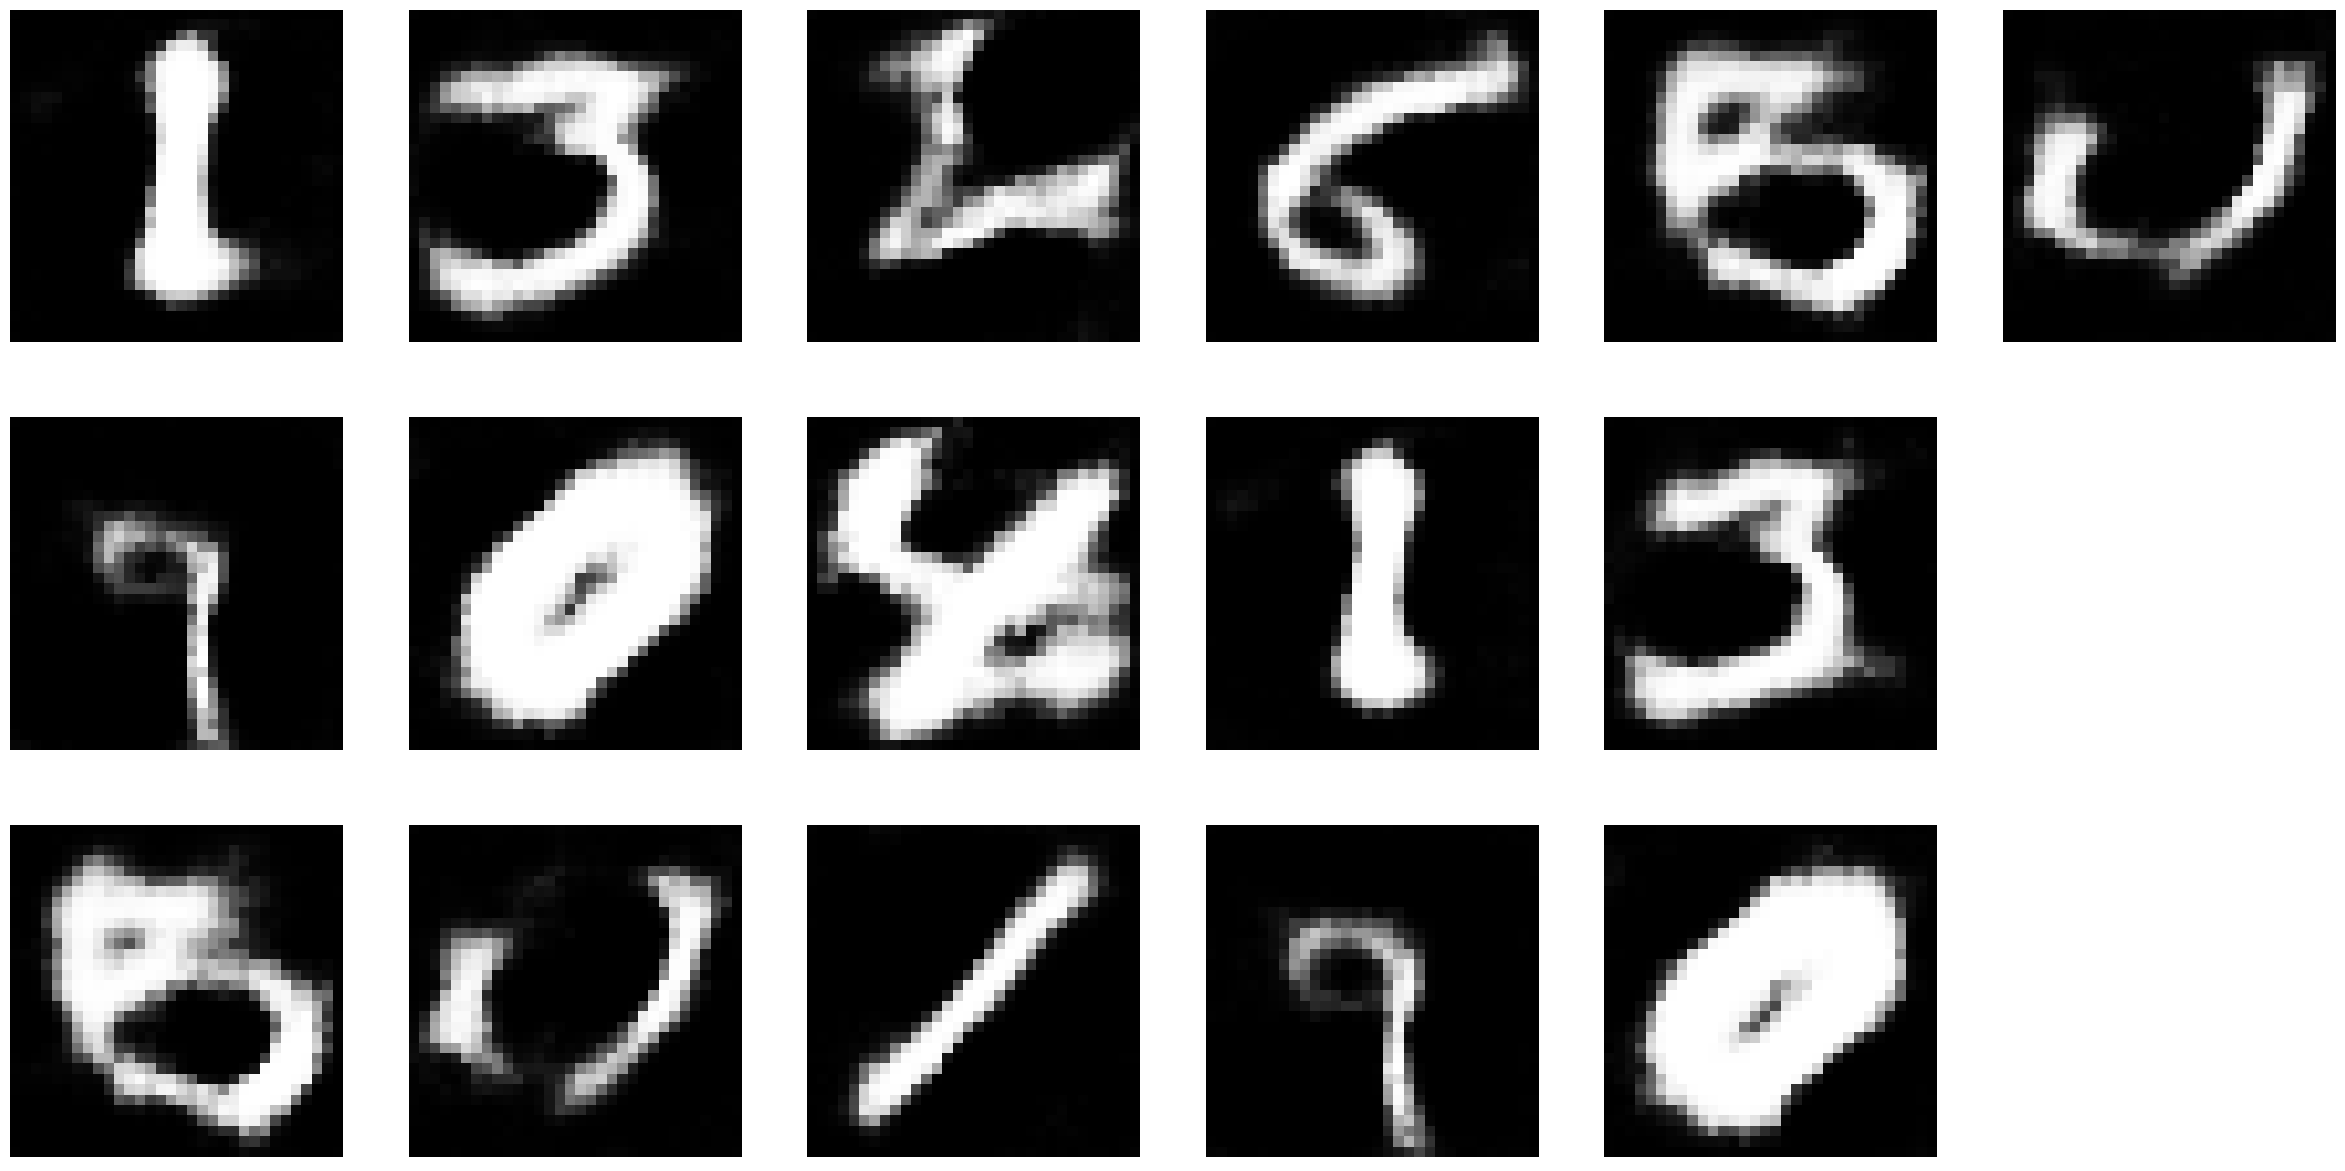

Iteration 469/469	[Epoch 18/20]	Losses:	KL = 47.5330 	L2 = 10.4625	CE = 0.0211: : 469it [00:09, 51.33it/s]
Iteration 469/469	[Epoch 19/20]	Losses:	KL = 47.3774 	L2 = 10.2810	CE = 0.0210: : 469it [00:09, 50.84it/s]
Iteration 469/469	[Epoch 20/20]	Losses:	KL = 47.2218 	L2 = 10.1270	CE = 0.0209: : 469it [00:08, 54.08it/s]


In [6]:
visualize_noise = torch.randn(16, latent_size, 1, 1).float().to(device)
class_indices = torch.arange(16) % num_classes  # shape (16,)
one_hot = torch.nn.functional.one_hot(class_indices, num_classes=num_classes).float().to(device).unsqueeze(-1).unsqueeze(-1)
visualize_noise = torch.cat([visualize_noise, one_hot], dim=1)

for epoch in range(num_epochs):
    pbar = tqdm(enumerate(data_loader))
    enc.train()
    dec.train()
    count = 0
    kl_sum = 0
    ce_sum = 0
    l2_sum = 0
    for i, (data, _) in pbar:
        optimizer.zero_grad()
        x = data.to(device)
        b = x.shape[0]
        z = enc(x, normal_generator)
        kl_loss = enc.z_kl
        ce_loss = enc.c_ce
        reconstructed = dec(z.reshape(b,latent_size+num_classes,1,1))
        l2_loss = ((reconstructed - x)**2).sum()
        vae_loss = kl_loss + l2_loss 
        # some threshold to prevent ce overfitting
        if ce_loss.item()>0.025:
            vae_loss += ce_loss
        vae_loss.backward()
        optimizer.step()
        
        count += b
        kl_sum += kl_loss.item()
        ce_sum += ce_loss.item()
        l2_sum += l2_loss.item()
        
        kl_loss_show = '{:.4f}'.format(kl_sum/count)
        ce_loss_show = '{:.4f}'.format(ce_sum/count)
        l2_loss_show = '{:.4f}'.format(l2_sum/count)
        pbar.set_description(f'Iteration {i+1}/{len(data_loader)}\t[Epoch {epoch+1}/{num_epochs}]\tLosses:\tKL = {kl_loss_show} \tL2 = {l2_loss_show}\tCE = {ce_loss_show}')
    
    # visualize every 4 epochs
    if epoch%4==0:
        with torch.no_grad():
            dec.eval()
            pred = dec(visualize_noise.to(device).float())
            plotter(pred.cpu())

In [44]:
torch.save({
    "encoder": enc.state_dict(),
    "decoder": dec.state_dict()
}, "weights/m2_weights.pt")

## Inference
In addition to $\mathbf{z}$, we also need to give the decoder a class to condition on. Let's try with the class $c=0$ first

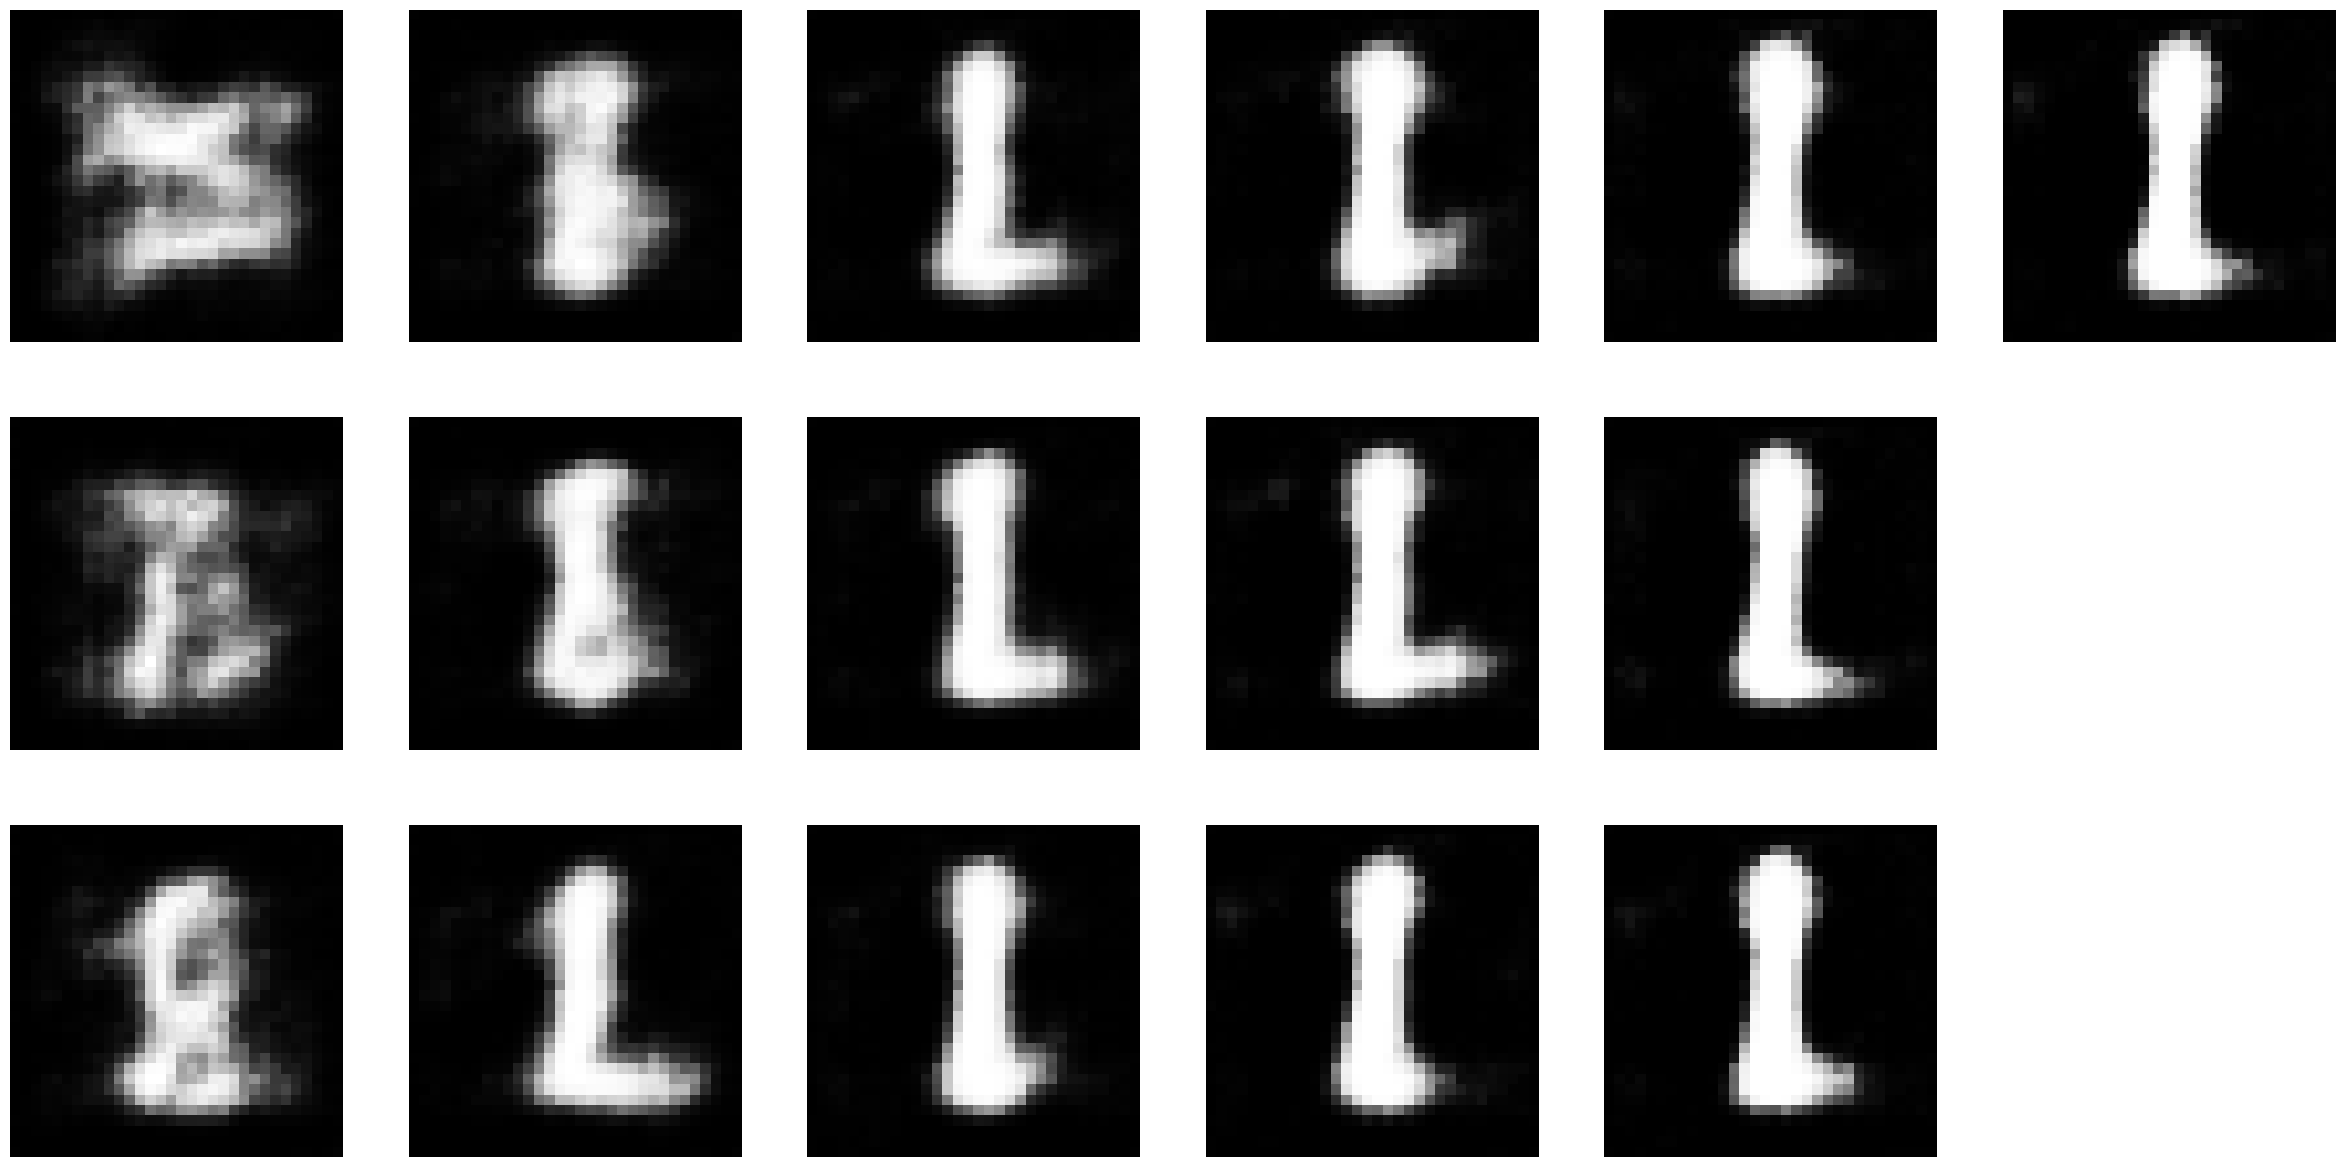

In [7]:
class_index = 0

noise = torch.randn(16, latent_size, 1, 1).float().to(device)
one_hot = torch.nn.functional.one_hot((torch.ones(16)*class_index).long(), num_classes=num_classes).float().to(device).unsqueeze(-1).unsqueeze(-1)
prob = (torch.arange(16)/16).to(device).reshape(-1,1,1,1)
noise = torch.cat([noise, one_hot*prob], dim=1)

with torch.no_grad():
    dec.eval()
    pred = dec(noise.to(device).float())
    plotter(pred.cpu())

okay, moving on to class $c=1$

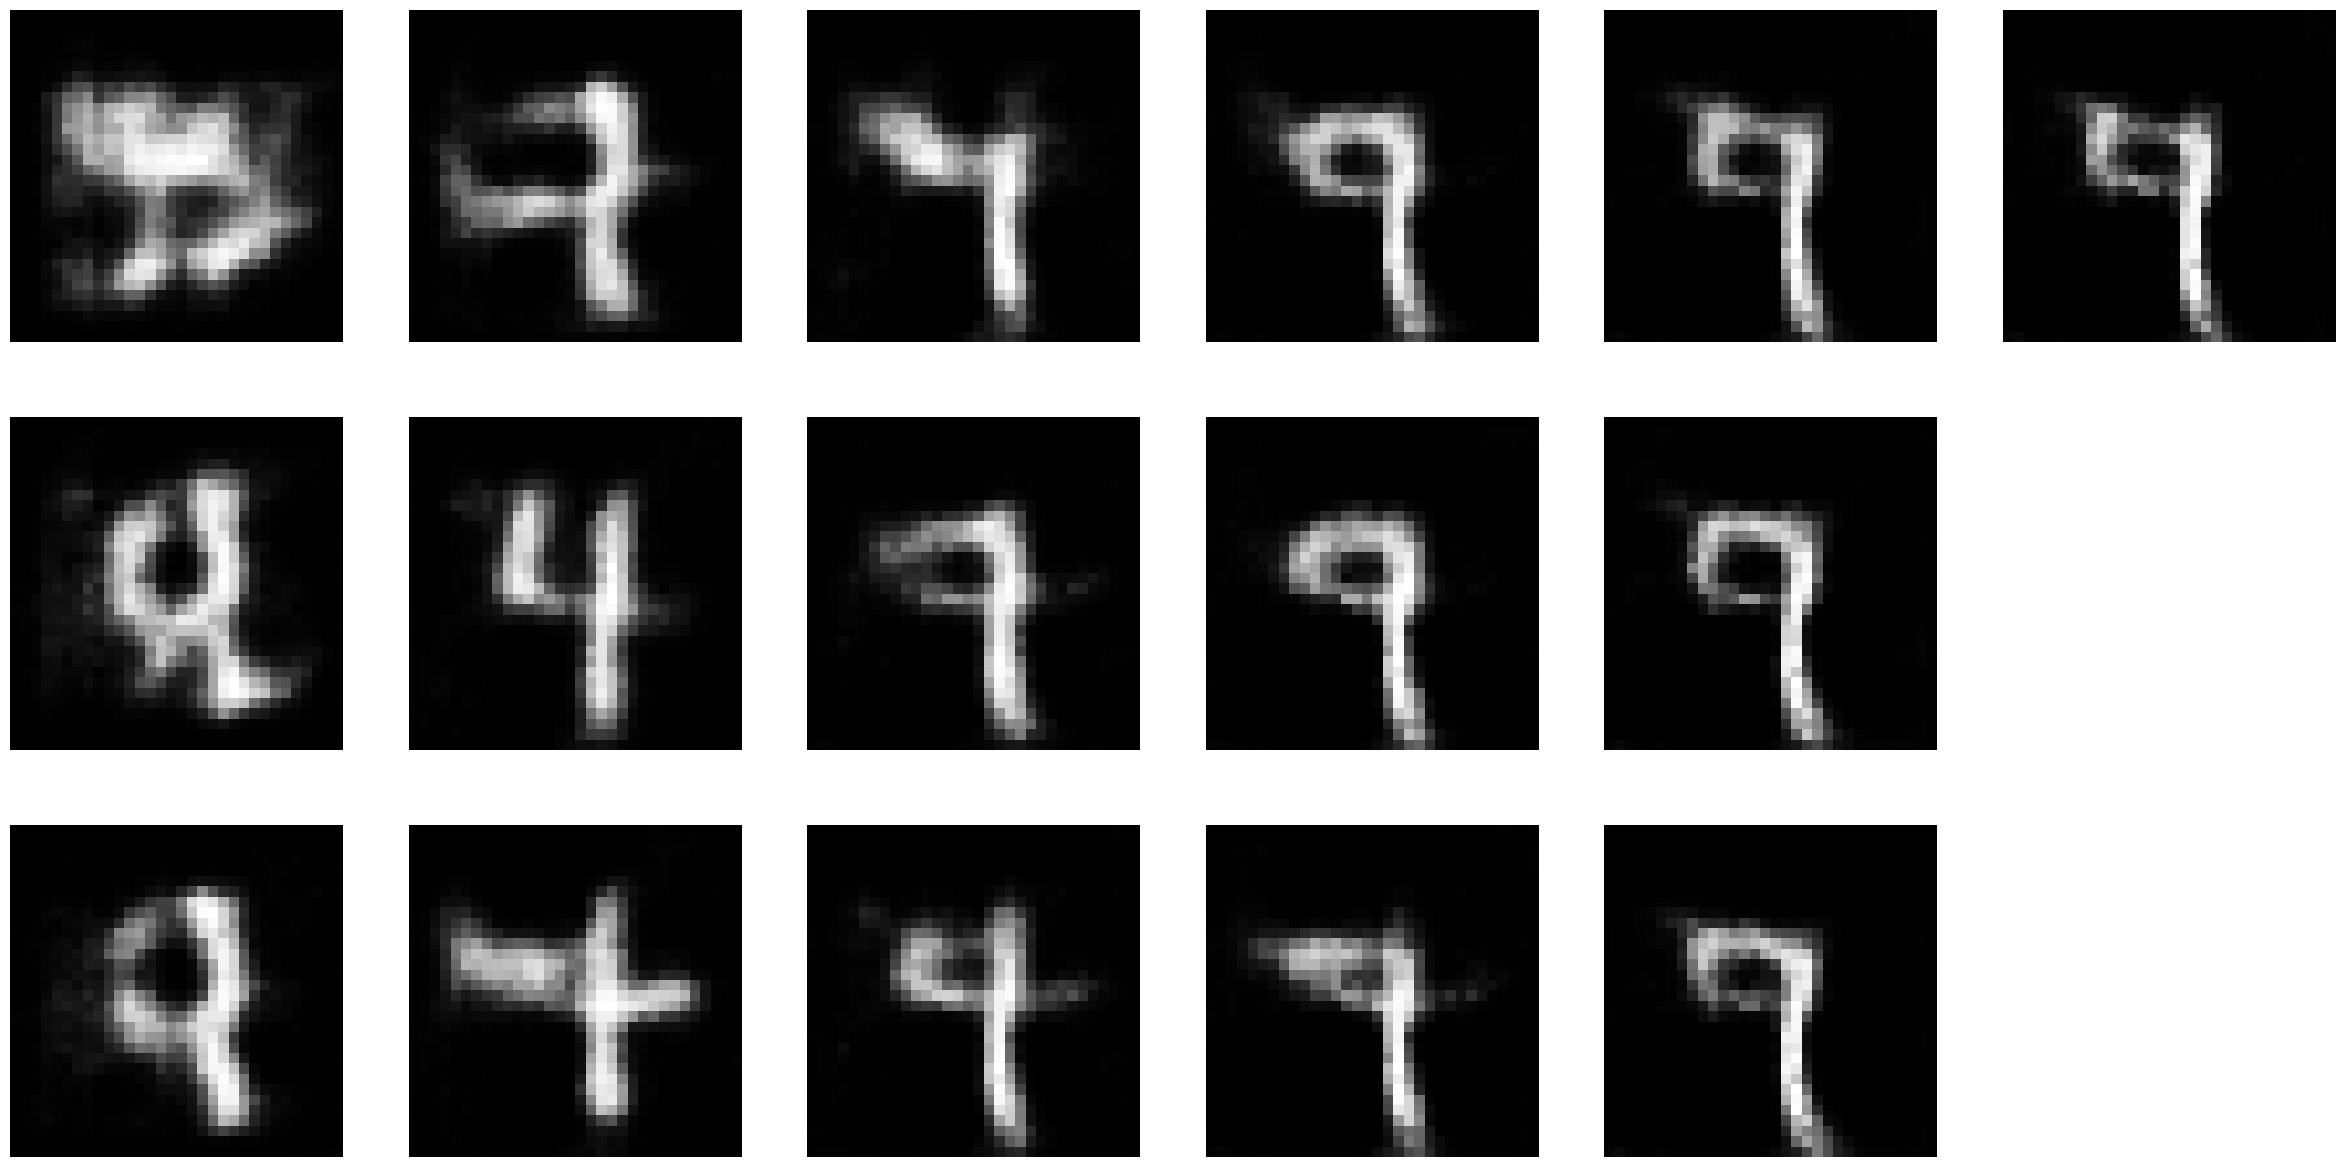

In [8]:
class_index = 1

noise = torch.randn(16, latent_size, 1, 1).float().to(device)
one_hot = torch.nn.functional.one_hot((torch.ones(16)*class_index).long(), num_classes=num_classes).float().to(device).unsqueeze(-1).unsqueeze(-1)
prob = (torch.arange(16)/16).to(device).reshape(-1,1,1,1)
noise = torch.cat([noise, one_hot*prob], dim=1)

with torch.no_grad():
    dec.eval()
    pred = dec(noise.to(device).float())
    plotter(pred.cpu())

interpolating from two classes

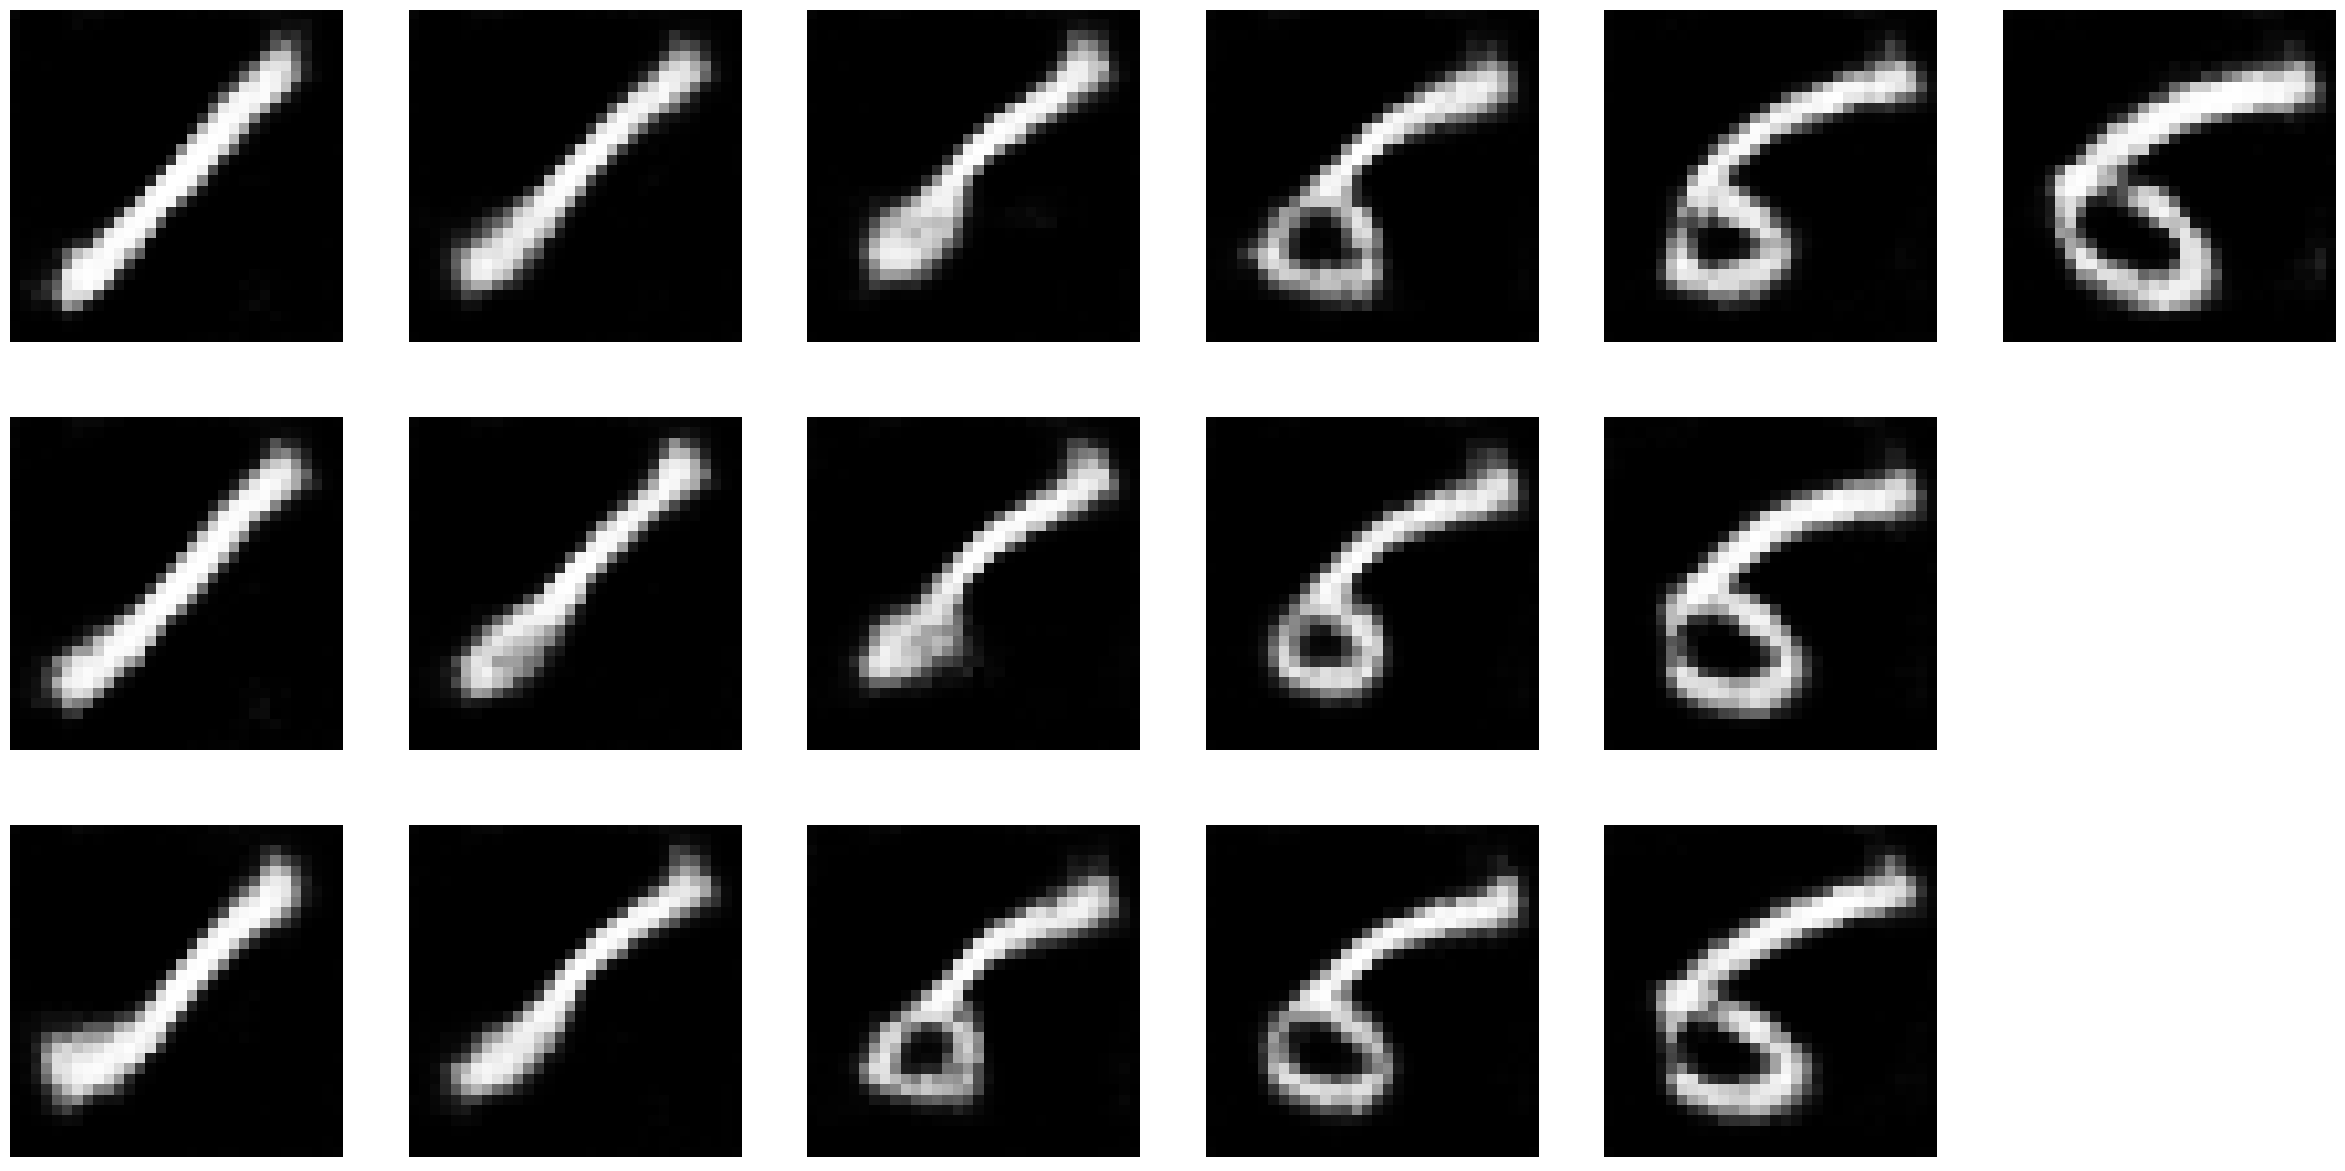

In [19]:
class_index = 2

noise = torch.randn(16, latent_size, 1, 1).float().to(device)
z1 = torch.nn.functional.one_hot(torch.tensor(8), num_classes=num_classes).float()
z2 = torch.nn.functional.one_hot(torch.tensor(9), num_classes=num_classes).float()
alphas = torch.linspace(0, 1, steps=16).unsqueeze(1) 
interpolated = (1 - alphas) * z1 + alphas * z2
noise = torch.cat([noise, interpolated.to(device).unsqueeze(-1).unsqueeze(-1)], dim=1)

with torch.no_grad():
    dec.eval()
    pred = dec(noise.to(device).float())
    plotter(pred.cpu())

Even with cross entropy clipping, we can notice that over time, the $c$ term of ELBO dominates, causing similar looking images to be generated repeatedly and hence hindering generation diversity of the regular VAE. This is because the M2 model is designed to work in a semi-supervised setting. A completely unsupervised model leads to $c|\mathbf{x}$ not to be learned properly, which is shown further by the poor clustering capabilities.

In [37]:
pbar = tqdm(enumerate(data_loader))
y_true = []
y_pred = []
for i, (data, y) in pbar:
    with torch.no_grad():
        x = data.to(device)
        b = x.shape[0]
        z = enc(x, normal_generator)
        y_pred.append(z[:,-10:].argmax(-1).cpu())
        y_true.append(y)
y_true = torch.hstack(y_true).numpy()
y_pred = torch.hstack(y_pred).numpy()
y_pred = align_hard_labels(y_pred, y_true, num_classes)

469it [00:07, 58.76it/s]


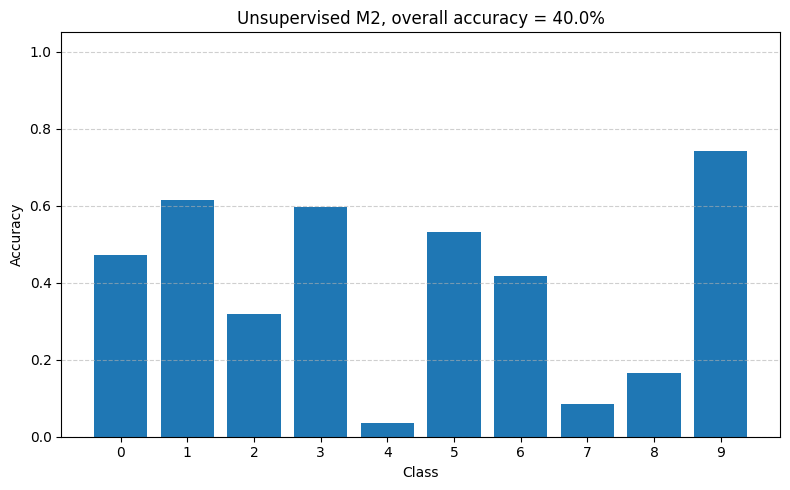

In [38]:
acc = np.sum(y_pred == y_true)/len(y_true)
plot_accuracy(y_pred, y_true, 10, title=f"Unsupervised M2, overall accuracy = {round(acc*100,2)}%")

The confusion matrix helps detect misclassifications

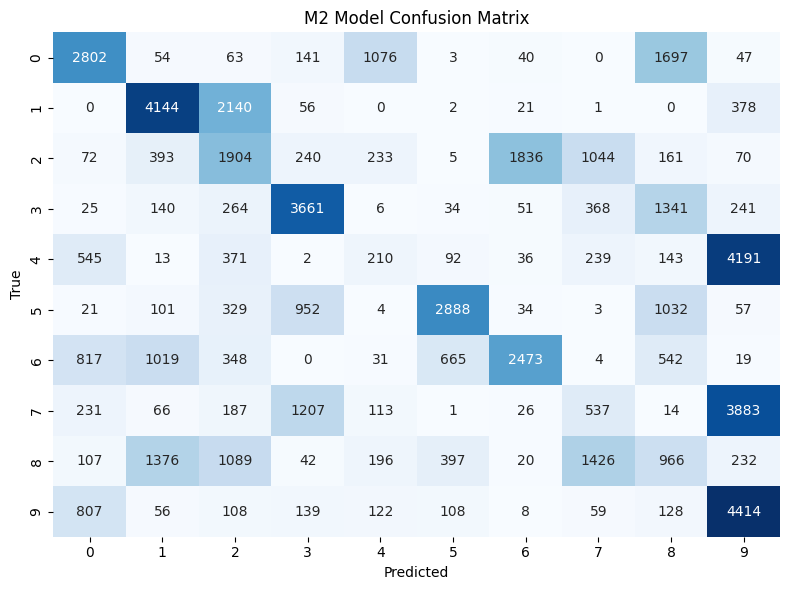

In [43]:
# Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('M2 Model Confusion Matrix')
plt.tight_layout()
plt.show()